In [2]:
import pandas as pd
import numpy as np
import pickle
import nltk
import re
import string
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import spacy
from collections import Counter
import scipy.sparse as ss
from sklearn import datasets
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read in the transcripts
with open('transcripts.pickle','rb') as read_file:
    transcripts = pickle.load(read_file)

## Create df of 5mins of text/ row

In [ ]:
def bin_5min_blocks(df, key):
    text_list = []
    time_list = []
    key_list = []
    i=0
    while i < len(df):
        current_time = df.start.iloc[i]
        current_text = ''
        while (i < len(df)) and (df.start.iloc[i] <= current_time+300):
            current_text = current_text + ' ' + df.text.iloc[i]
            i +=1
        time_list.append(current_time)
        text_list.append(current_text)
        key_list.append(key)
    return pd.DataFrame(list(zip(key_list, time_list, text_list)),\
                        columns=['episode', 'time','text'])

In [ ]:
binned_df = pd.DataFrame(columns=['episode','time','text'])
for key in transcripts.keys():
    binned_df = binned_df.append(bin_5min_blocks(pd.DataFrame(transcripts[key]), key))

In [ ]:
binned_df.shape

In [ ]:
# Pickle the 5 min bin df
with open('binned_df.pickle', 'wb') as to_write:
    pickle.dump(binned_df, to_write)

# spaCy

In [ ]:
# Read in the bin df
with open('binned_df.pickle','rb') as read_file:
    binned_df = pickle.load(read_file)

binned_df = binned_df.reset_index().drop(columns='index')

In [ ]:
# Load spaCy's english core module

nlp = spacy.load('en_core_web_sm')

### Tokenize

In [ ]:
# Tokenization (takes 5-10 min to run)

binned_df['spacy_doc'] = list(nlp.pipe(binned_df.text))

# to tokenize one string:
# doc = nlp(text)

In [ ]:
# Pickle the 5 min bin tokenized text (1.59 GB)
with open('token_5min_df.pickle', 'wb') as to_write:
    pickle.dump(binned_df, to_write)

In [6]:
# Read in the 5 min tokenized text
with open('token_5min_df.pickle','rb') as read_file:
    binned_df = pickle.load(read_file)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Put Nouns and Adjectives in a string for each doc

In [7]:
def key_words(row):
    current_string = ''
    for token in row['spacy_doc']:
        if (token.is_stop == False) and ((token.pos_ == 'NOUN') or (token.pos_ == 'ADJ')):
            current_word = token.lemma_
            current_string = current_string + current_word + ' '
    return current_string

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
binned_df['key_words'] = binned_df.apply(key_words ,axis=1)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Vectorize

In [9]:
vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df=0.3)
dtm = vectorizer.fit_transform(binned_df.key_words)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Fit LDA Model

In [10]:
lda = LatentDirichletAllocation(n_components=16, random_state=0)
doc_topic_array = lda.fit_transform(dtm)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pickle Model, dtm and vectorizer

In [11]:
# Pickle the LDA Model, dtm, and vectorizer

mmv = [lda, dtm, vectorizer, doc_topic_array]

with open('mmv_5min.pickle', 'wb') as to_write:
    pickle.dump(mmv, to_write)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Read in the LDA Model
with open('mmv_5min.pickle','rb') as read_file:
    mmv = pickle.load(read_file)

lda = mmv[0]
dtm = mmv[1]
vectorizer = mmv[2]
doc_topic_array = mmv[3]

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### pyLDAvis

In [13]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, dtm, vectorizer, mds='mmds')

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.049489  0.096537       1        1  11.718838
4      0.056653  0.042013       2        1  11.386334
6     -0.013507  0.261311       3        1  11.223670
9      0.142905  0.197054       4        1   8.621766
7     -0.204217  0.209423       5        1   8.245150
12     0.053294 -0.260096       6        1   7.968779
0      0.050422  0.219747       7        1   7.722403
1      0.003453 -0.109530       8        1   7.353923
3     -0.302578  0.097065       9        1   6.913266
11     0.282869  0.109834      10        1   3.939080
15     0.123931 -0.091093      11        1   3.927340
13    -0.264628 -0.028599      12        1   3.056620
10     0.309462 -0.064245      13        1   2.298855
5     -0.250646 -0.171119      14        1   1.961786
14    -0.138515 -0.262489      15        1   1.861484
8      0.200591 -0.245812      16        1   1.800705, topic_info=            Term         Freq        Total Category  logprob  loglift
12489       tire  1013.000000  1013.000000  Default  30.0000  30.0000
12236       team  1750.000000  1750.000000  Default  29.0000  29.0000
7901      muscle  1827.000000  1827.000000  Default  28.0000  28.0000
12335       test   997.000000   997.000000  Default  27.0000  27.0000
12643    trainer  1405.000000  1405.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
13654      wheel    32.791024  1023.945485  Topic16  -5.3591   0.5757
11088  situation    31.015143   789.856057  Topic16  -5.4148   0.7796
8582        pace    28.744872   567.166475  Topic16  -5.4908   1.0348
6980        life    28.559141   750.976758  Topic16  -5.4973   0.7476
7606        mile    28.932040  1079.472789  Topic16  -5.4843   0.3977

[1164 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
45         3  0.712150  acceleration
45         4  0.173695  acceleration
45        10  0.112902  acceleration
52         1  0.024772        access
52         2  0.041286        access
...      ...       ...           ...
13891      6  0.089597       youtube
13891      8  0.689894       youtube
13891     11  0.017919       youtube
13918      6  0.958790        zipper
13921     15  0.808735        zombie

[5076 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 7, 10, 8, 13, 1, 2, 4, 12, 16, 14, 11, 6, 15, 9])

In [14]:
# Get top words for each  topic
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
display_topics(lda, vectorizer.get_feature_names(), 16)


Topic  0
weight, strength, muscle, pound, fat, leg, fiber, strong, endurance, calorie, cyclist, type, watt, mass, gym, force

Topic  1
coach, thank, cycling, awesome, trainerroad, group, episode, live, trainer, video, cyclist, team, fun, new, forum, pro

Topic  2
plan, volume, recovery, stress, base, fitness, season, event, intensity, sweet, life, important, phase, month, rest, build

Topic  3
food, bottle, calorie, gram, carbohydrate, water, nutrition, fat, gel, station, carb, caffeine, protein, morning, aid, meal

Topic  4
mountain, climb, mile, cross, section, flat, trail, skill, track, technical, effort, group, speed, rider, stage, fun

Topic  5
test, ramp, collagen, breath, breathing, air, cold, allergy, mouth, nose, asthma, nitrate, interesting, meat, result, number

Topic  6
team, rider, group, field, line, lap, wheel, sprint, turn, breakaway, corner, crit, wind, speed, sprinter, attack

Topic  7
muscle, study, blood, cell, effect, performance, exercise, fat, endurance, brain, 

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# make weight readable
topic_list = ['strength','tr_chat','training_plan_structure','nutrition',\
              'mtb_racing','testing_medical','road_racing','physiology',\
              'interuptions','workout_structure','bike_mechanics','trainer_technical',\
              'riding_technical','heat_sweat','special_physical_cases','goals']
doc_topic = pd.DataFrame(doc_topic_array, columns = topic_list)
doc_topic_df = pd.concat([binned_df[['episode','time']], doc_topic], axis=1)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
doc_topic_df['time'] = doc_topic_df['time']/60

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
doc_topic_df[doc_topic_df['episode'] == 'htDYWoZBVw0']

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,episode,time,strength,tr_chat,training_plan_structure,nutrition,mtb_racing,testing_medical,road_racing,physiology,interuptions,workout_structure,bike_mechanics,trainer_technical,riding_technical,heat_sweat,special_physical_cases,goals
639,htDYWoZBVw0,0.000000,0.000512,0.454409,0.180665,0.000512,0.081514,0.106552,0.000512,0.000512,0.000512,0.000512,0.000512,0.080154,0.091583,0.000512,0.000512,0.000512
640,htDYWoZBVw0,5.048667,0.000573,0.330714,0.258586,0.000573,0.123037,0.000573,0.000573,0.000573,0.000573,0.245662,0.000573,0.000573,0.035692,0.000573,0.000573,0.000573
641,htDYWoZBVw0,10.078333,0.137287,0.000638,0.154267,0.000638,0.238103,0.272489,0.190839,0.000638,0.000638,0.000638,0.000638,0.000638,0.000638,0.000638,0.000638,0.000638
642,htDYWoZBVw0,15.103333,0.000651,0.000651,0.000651,0.057478,0.000651,0.054037,0.000651,0.000651,0.000651,0.209063,0.000651,0.000651,0.044135,0.238995,0.121679,0.268754
643,htDYWoZBVw0,20.123167,0.000422,0.134900,0.000422,0.000422,0.000422,0.000422,0.000422,0.726148,0.000422,0.000422,0.133462,0.000422,0.000422,0.000422,0.000422,0.000422
644,htDYWoZBVw0,25.127317,0.134415,0.000295,0.000295,0.000295,0.000295,0.000295,0.000295,0.842127,0.000295,0.019626,0.000295,0.000295,0.000295,0.000295,0.000295,0.000295
645,htDYWoZBVw0,30.157150,0.000422,0.000422,0.000451,0.000422,0.111047,0.000422,0.000422,0.667047,0.129505,0.074195,0.000422,0.000422,0.013533,0.000422,0.000422,0.000422
646,htDYWoZBVw0,35.189000,0.000484,0.000484,0.493759,0.000484,0.000484,0.000484,0.000484,0.175850,0.307314,0.000484,0.000484,0.000484,0.000484,0.000484,0.017262,0.000484
647,htDYWoZBVw0,40.200167,0.000473,0.000473,0.573948,0.000473,0.000473,0.000473,0.000473,0.072066,0.000473,0.327854,0.000473,0.000473,0.020449,0.000473,0.000473,0.000473
648,htDYWoZBVw0,45.247817,0.062658,0.149344,0.536022,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,0.245949,0.000500,0.000528


# PCA

In [93]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(doc_topic_array)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

In [91]:
pca_df = pd.DataFrame(pca_features, columns=['pc1','pc2'])
label_names = doc_topic.columns
pca_df['label'] = doc_topic.idxmax(axis=1)
colors = ['red',
 'darkorange',
 'black',
 'cyan',
 'lightgreen',
 'darkblue',
 'lightblue',
 'darkmagenta',
 'magenta',
 'saddlebrown',
 'burlywood',
 'lightgray',
 'yellow',
 'lightcoral',
 'pink',
 'olive']

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


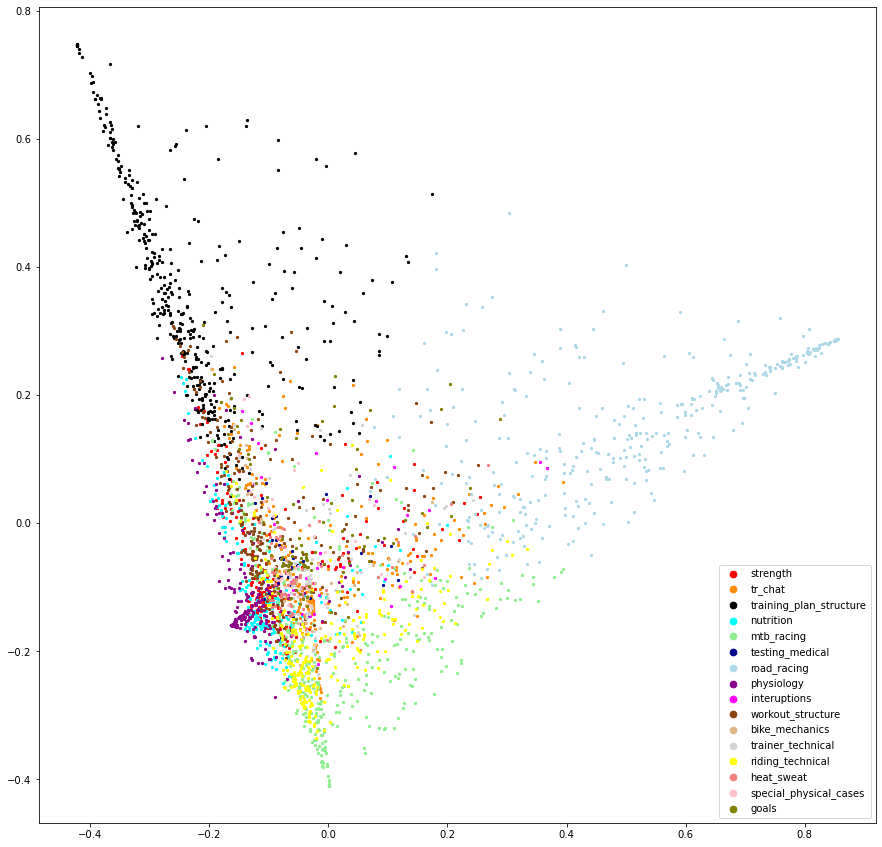

In [92]:
plt.figure(figsize=[15,15])
for i,c in zip(label_names, colors):
    plt.scatter(pca_df[pca_df['label']==i].pc1, pca_df[pca_df['label']==i].pc2, color=c,s=5, label=i)
plt.legend(loc='lower right',markerscale=3);

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


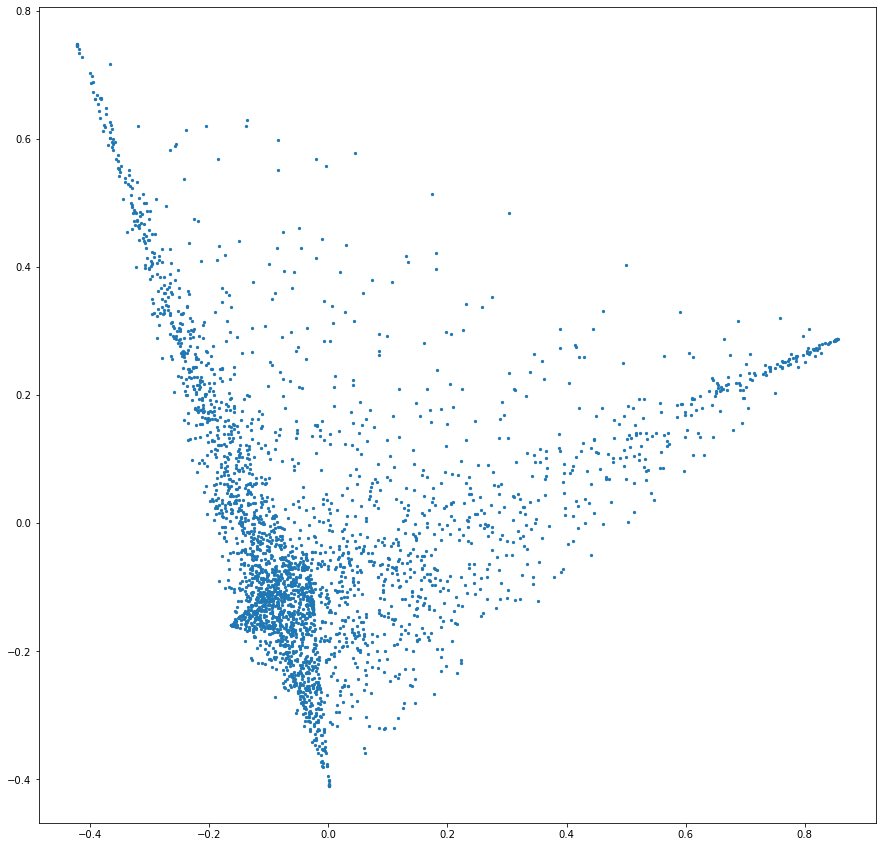

In [70]:
plt.figure(figsize=[15,15])
plt.scatter(pca_features[:,0],pca_features[:,1],s=5)

# KMeans Clustering

In [40]:
def display_cluster(X, km=[], num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], c=color[0], alpha=alpha, s=s)
        
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


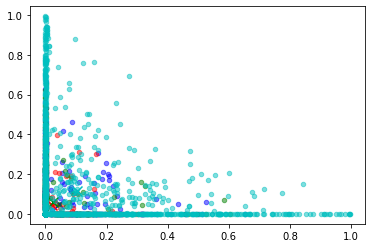

In [42]:
from sklearn.cluster import KMeans

num_clusters = 4
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic_array)
display_cluster(doc_topic_array,km,num_clusters)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
doc_topic_df

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,episode,time,strength,tr_chat,training_plan_structure,nutrition,mtb_racing,testing_medical,road_racing,physiology,interuptions,workout_structure,bike_mechanics,trainer_technical,riding_technical,heat_sweat,special_physical_cases,goals
0,xXXIACCJ2io,1.006650,0.000437,0.993444,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437
1,xXXIACCJ2io,6.007983,0.088402,0.196738,0.236611,0.000488,0.000488,0.000488,0.000488,0.106985,0.066531,0.000488,0.013949,0.000488,0.000488,0.000488,0.180956,0.105921
2,xXXIACCJ2io,11.029333,0.000481,0.094218,0.165224,0.090871,0.000481,0.000481,0.000481,0.536425,0.000481,0.000481,0.000481,0.000481,0.107973,0.000481,0.000481,0.000481
3,xXXIACCJ2io,16.039983,0.205524,0.000539,0.000539,0.000539,0.091832,0.000539,0.047034,0.306622,0.000539,0.000539,0.124947,0.069838,0.149355,0.000539,0.000539,0.000539
4,xXXIACCJ2io,21.056000,0.000539,0.138565,0.087610,0.000539,0.142810,0.000539,0.332240,0.000539,0.060112,0.000539,0.000539,0.000539,0.233276,0.000539,0.000539,0.000539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2959,eWZVAazaDco,45.183833,0.000431,0.000431,0.149210,0.000431,0.355553,0.000431,0.106171,0.000431,0.211462,0.000431,0.000431,0.000431,0.065040,0.063674,0.000431,0.045012
2960,eWZVAazaDco,50.205000,0.000460,0.125091,0.000460,0.000460,0.169531,0.000460,0.217823,0.000460,0.000460,0.000460,0.000460,0.000460,0.000460,0.482040,0.000460,0.000460
2961,eWZVAazaDco,55.225983,0.000548,0.000548,0.621432,0.000548,0.000548,0.000548,0.312838,0.000548,0.000548,0.058603,0.000548,0.000548,0.000548,0.000548,0.000548,0.000548
2962,eWZVAazaDco,60.243167,0.242800,0.000492,0.180193,0.193415,0.000492,0.000492,0.000492,0.117561,0.000492,0.066776,0.194334,0.000492,0.000492,0.000492,0.000492,0.000492


# Episode topics

In [99]:
colors = ['red', 'darkorange', 'black', 'cyan', 'lightgreen', 'darkblue', 'lightblue', 'darkmagenta', 'magenta', 'saddlebrown',\
           'burlywood', 'lightgray', 'yellow', 'lightcoral', 'pink', 'olive']

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [156]:
tmp_df = doc_topic_df.copy()

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [157]:
tmp_df

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,episode,time,strength,tr_chat,training_plan_structure,nutrition,mtb_racing,testing_medical,road_racing,physiology,interuptions,workout_structure,bike_mechanics,trainer_technical,riding_technical,heat_sweat,special_physical_cases,goals
0,xXXIACCJ2io,1.006650,0.000437,0.993444,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437,0.000437
1,xXXIACCJ2io,6.007983,0.088402,0.196738,0.236611,0.000488,0.000488,0.000488,0.000488,0.106985,0.066531,0.000488,0.013949,0.000488,0.000488,0.000488,0.180956,0.105921
2,xXXIACCJ2io,11.029333,0.000481,0.094218,0.165224,0.090871,0.000481,0.000481,0.000481,0.536425,0.000481,0.000481,0.000481,0.000481,0.107973,0.000481,0.000481,0.000481
3,xXXIACCJ2io,16.039983,0.205524,0.000539,0.000539,0.000539,0.091832,0.000539,0.047034,0.306622,0.000539,0.000539,0.124947,0.069838,0.149355,0.000539,0.000539,0.000539
4,xXXIACCJ2io,21.056000,0.000539,0.138565,0.087610,0.000539,0.142810,0.000539,0.332240,0.000539,0.060112,0.000539,0.000539,0.000539,0.233276,0.000539,0.000539,0.000539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2959,eWZVAazaDco,45.183833,0.000431,0.000431,0.149210,0.000431,0.355553,0.000431,0.106171,0.000431,0.211462,0.000431,0.000431,0.000431,0.065040,0.063674,0.000431,0.045012
2960,eWZVAazaDco,50.205000,0.000460,0.125091,0.000460,0.000460,0.169531,0.000460,0.217823,0.000460,0.000460,0.000460,0.000460,0.000460,0.000460,0.482040,0.000460,0.000460
2961,eWZVAazaDco,55.225983,0.000548,0.000548,0.621432,0.000548,0.000548,0.000548,0.312838,0.000548,0.000548,0.058603,0.000548,0.000548,0.000548,0.000548,0.000548,0.000548
2962,eWZVAazaDco,60.243167,0.242800,0.000492,0.180193,0.193415,0.000492,0.000492,0.000492,0.117561,0.000492,0.066776,0.194334,0.000492,0.000492,0.000492,0.000492,0.000492


In [158]:
ep1 = tmp_df[tmp_df['episode']=='xXXIACCJ2io']
ep1_norm = tmp_df[tmp_df['episode']=='xXXIACCJ2io']



/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [159]:
for i in range(len(ep1.columns)):
    if i < 3:
        ep1_norm[ep1_norm.columns[i]] = ep1_norm.iloc[:,i]
    else:
        ep1_norm[ep1_norm.columns[i]] = ep1_norm.iloc[:,i] + ep1_norm.iloc[:,i-1]

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-159-de03f13d9feb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ep1_norm[ep1_norm.columns[i]] = ep1_norm.iloc[:,i]
<ipython-input-159-de03f13d9feb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


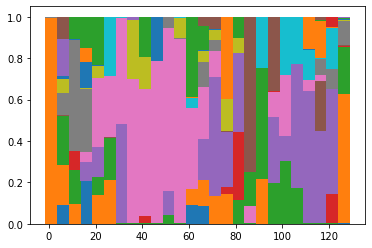

In [161]:

plt.bar(ep1['time'], ep1['strength'], label='strength',width=5)

for i in range(3,18):
    plt.bar(ep1['time'], ep1.iloc[:,i], bottom=ep1_norm.iloc[:,i-1],width=5.1)

